In [1]:
import kinetics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'
print(kinetics.__version__)

1.4.3


In [2]:
ired = kinetics.Tri_Tri_seq_eq(kcat='ired_kcat',
                              kma='ired_km_nadph', kmb='ired_km_aldehyde', kmc='ired_km_nh2',
                              kmp='ired_km_nadp', kmq='ired_km_amine', kmr='ired_km_h2o',
                              keq='ired_keq',
                              a='nadph', b='aldehyde', c='nh2', p='nadp', q='amine', r='h2o', enz='ired',
                              substrates=['nadph', 'aldehyde', 'nh2'], products=['nadp', 'amine'])

ired.parameter_distributions = {'ired_km_nadph': (20, 200),
                                'ired_km_aldehyde': (500, 10000),
                                'ired_km_nh2': (500, 10000),
                                'ired_km_nadp': (20, 200),
                                'ired_km_amine': (500, 10000),
                                'ired_km_h2o': (500, 10000),
                                'ired_kcat': (10, 200),
                                'ired_keq': (11100000,929000000)}

adh = kinetics.Bi_Bi_sep_eq(kcat='adh_kcat',
                            kma='adh_km_nadp', kmb='adh_km_alcohol',
                            kmp='adh_km_nadph', kmq='adh_km_aldehyde',
                            keq='adh_keq',
                            a='nadp', b='alcohol', p='nadph', q='aldehyde', enz='adh',
                            substrates=['nadp', 'alcohol'], products=['nadph', 'aldehyde'])


adh.parameter_distributions = {'adh_km_nadph': (20, 200),
                               'adh_km_alcohol': (500, 10000),
                               'adh_km_nadp': (20, 200),
                               'adh_km_aldehyde': (500, 10000),
                               'adh_kcat': (10, 200),
                               'adh_keq': (0.00106, 0.00289)}

In [3]:
# Set up the model
model = kinetics.Model()

# Add reactions
model.append(ired)
model.append(adh)

In [4]:
# Set time
model.set_time(0, 60*24, 200) #24 hours 

# Set starting concentrations with no error
# Issue setting concs to 0, so initialise at 1.
model.species = {"ired" : 320,
                 "adh": 320,
                 "nadph": 1,
                 "nadp": 499,
                 "alcohol": 9998,
                 "aldehyde": 1,
                 "amine": 1,
                 "nh2": 500000,
                 'h2o': 5500000}

# Command to prepare model for running.
model.setup_model()

In [5]:
# Run the model 1000 times, sampling from distributions
samples = kinetics.sample_uniforms(model, num_samples=1000)
outputs = kinetics.run_all_models(model, samples)
df95 = kinetics.dataframes_quartiles(model, outputs, quartile=95)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.19it/s]


-- Alcohol --


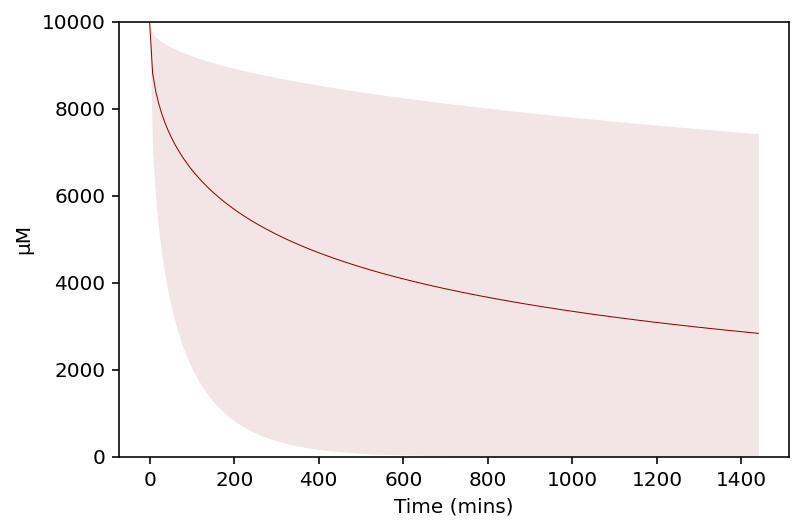

-- Aldehyde --


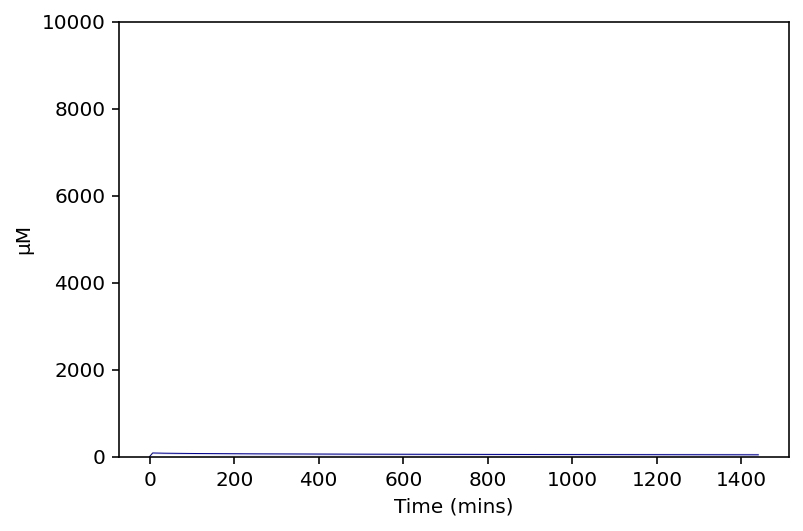

-- Amine --


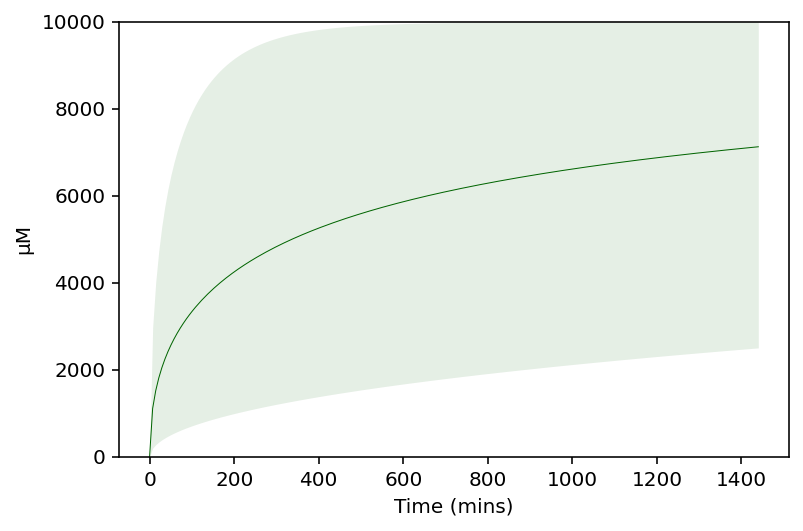

-- NADPH --


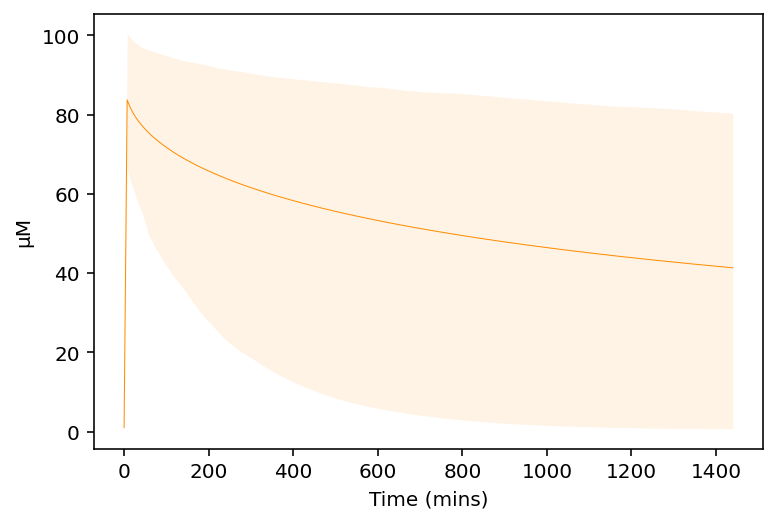

-- NADP --


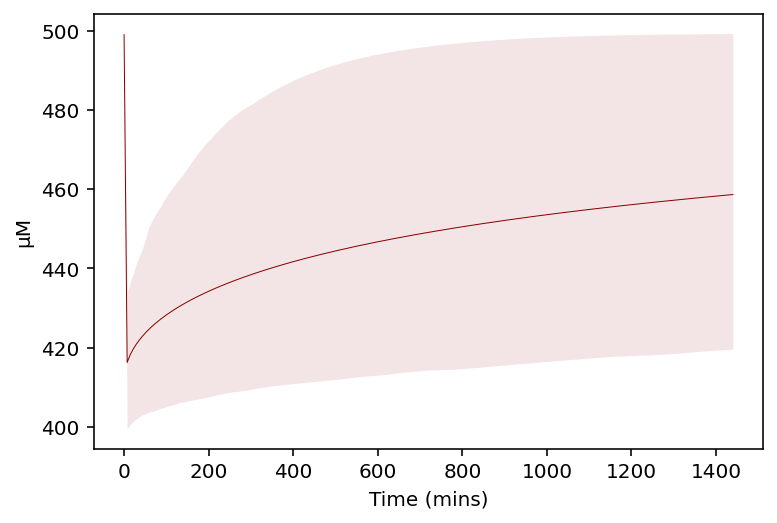

In [6]:
# Plot the confidence intervals
print("-- Alcohol --")
kinetics.plot_ci_intervals(['alcohol'], df95,
                           units=['μM', 'Time (mins)'],
                           alpha=0.1)
plt.ylim(0, 10000)
plt.show()


print("-- Aldehyde --")
kinetics.plot_ci_intervals(['aldehyde'], df95,
                           units=['μM', 'Time (mins)'],
                           alpha=0.1)
plt.ylim(0, 10000)
plt.show()

print("-- Amine --")
kinetics.plot_ci_intervals(['amine'], df95,
                           units=['μM', 'Time (mins)'],
                           alpha=0.1)
plt.ylim(0, 10000)
plt.show()


print("-- NADPH --")
kinetics.plot_ci_intervals(['nadph'], df95,
                           units=['μM', 'Time (mins)'],
                           alpha=0.1)
#plt.ylim(0, 500)
plt.show()


print("-- NADP --")
kinetics.plot_ci_intervals(['nadp'], df95,
                           units=['μM', 'Time (mins)'],
                           alpha=0.1)
#plt.ylim(0, 500)
plt.show()

## Sensitivity analysis

In [7]:
problem = kinetics.salib_problem(model)
sa_samples = kinetics.make_saltelli_samples(model, problem, 1000, second_order=False)

/Users/willfinnigan/.conda/envs/kinetics/lib/python3.9/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


In [8]:
outputs = kinetics.run_all_models(model, sa_samples)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16000/16000 [04:20<00:00, 61.42it/s]


In [9]:
timepoint = 1400
substrate = 'amine'
concs = kinetics.get_concentrations_at_timepoint(model, outputs, timepoint, substrate)
sobol = kinetics.analyse_sobal_sensitivity(problem, concs, second_order=False, num_resample=100, conf_level=0.95)

In [10]:
def plot_sa_total_sensitivity(df):
    """
    Plot the sensitivity analysis

    Args:
        df: Dataframe containing output of sensitivity analysis.
    """
    df.sort_values("ST", inplace=True, ascending=False)

    x_names = df.index.values
    x = np.arange(len(x_names))
    st = df['ST']
    st_err = df['ST_conf']

    plt.bar(x, st, align='center', yerr=st_err, edgecolor='black', color='#000090')
    plt.xticks(x, x_names, rotation=90)
    plt.ylabel("ST")

/Users/willfinnigan/.conda/envs/kinetics/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


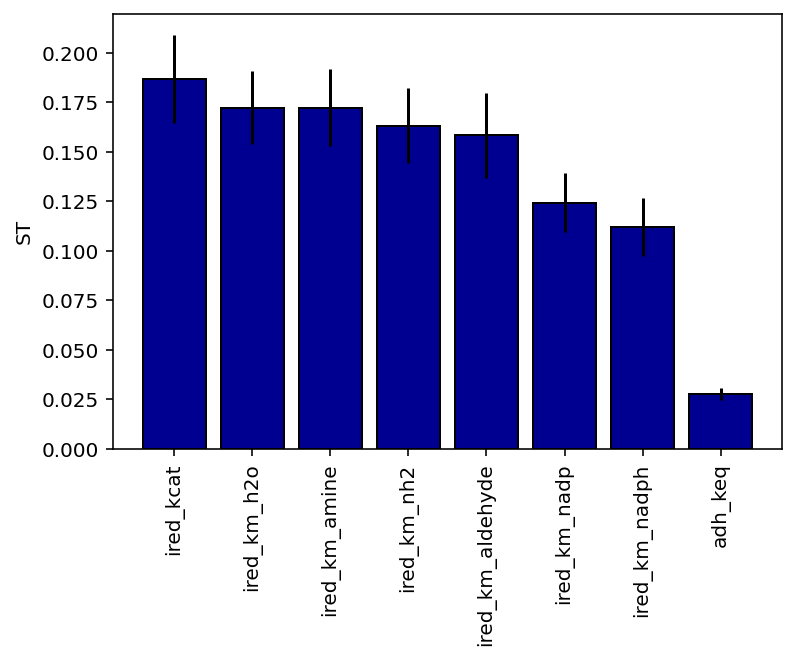

In [11]:
new_df = kinetics.remove_st_less_than(sobol, column='ST', less_than=0.005)
plot_sa_total_sensitivity(new_df)
plt.show()